In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection  import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
import numpy as np

In [2]:
seed = 123
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

# 1 Load and Process Data

In [39]:
# Download and preprocess the data
mnist = fetch_openml('mnist_784', version=1)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [42]:
X, y = mnist.data, mnist.target.astype('int64')
X = ((X/255.)-.5)*2

In [45]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state=seed)


# Convert to PyTorch tensors and add a dimension to match the CNN input format
X_train_tensor = torch.from_numpy(X_train.values).reshape(-1, 1, 28, 28)
y_train_tensor = torch.from_numpy(y_train.values)
X_test_tensor = torch.from_numpy(X_test.values).reshape(-1, 1, 28, 28)
y_test_tensor = torch.from_numpy(y_test.values)
X_val_tensor = torch.from_numpy(X_val.values).reshape(-1, 1, 28, 28)
y_val_tensor = torch.from_numpy(y_val.values)

In [46]:
print("Train data num:{}".format(X_train.shape[0]))
print("Test data num: {}".format(X_test.shape[0]))
print("Val data num:  {}".format(X_val.shape[0]))

Train data num:56000
Test data num: 9800
Val data num:  4200


In [47]:
# Create datasets and data loaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# 2 Create model

In [78]:
import torch.nn.functional as F

# Define the convolutional neural network model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, stride=1)
        self.conv2 = nn.Conv2d(6, 10, 3, stride=1)

        self.fc1 = nn.Linear(5760, 30)  # 5x5 is the size after two max pooling layers
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        
        x = self.conv2(x)
        x = torch.relu(x)
        x = x.view(batch_size, -1)
        
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        #x = F.softmax(x, dim=1)  # Apply softmax along the dimension representing classes

        return x

In [79]:
# Instantiate the model
model = CNN()

# Xavier initialization
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

model.apply(weights_init)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=5760, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)

# Train Model

In [81]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
num_epochs = 100
patience = 5

train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

best_valid_acc = 0
best_model = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)


cuda


In [82]:
no_improvement = 0
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    total= 0
    for inputs, labels in train_loader:
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        total += len(labels)
        
        _, predicted = torch.max(outputs, 1)
        train_acc += (predicted == labels).sum().item()
        
    train_loss /=  total
    train_acc /= total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.float()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # loss
            valid_loss += criterion(outputs, labels).item()

            # acc
            valid_acc += (predicted == labels).sum().item()
            total += len(predicted)

    valid_loss /= total
    valid_acc /= total
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    print("epoch：{} train loss:{:.4f}  train acc:{:.4f}  val loss: {:.4f} val acc: {:.4f} ".format(epoch, train_loss, train_acc, valid_loss, valid_acc))

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = model
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            break

    scheduler.step()

epoch：0 train loss:0.0043  train acc:0.9325  val loss: 0.0018 val acc: 0.9745 
epoch：1 train loss:0.0017  train acc:0.9749  val loss: 0.0017 val acc: 0.9736 
epoch：2 train loss:0.0012  train acc:0.9808  val loss: 0.0018 val acc: 0.9752 
epoch：3 train loss:0.0016  train acc:0.9766  val loss: 0.0026 val acc: 0.9624 
epoch：4 train loss:0.0012  train acc:0.9817  val loss: 0.0024 val acc: 0.9738 
epoch：5 train loss:0.0009  train acc:0.9864  val loss: 0.0020 val acc: 0.9781 
epoch：6 train loss:0.0007  train acc:0.9890  val loss: 0.0021 val acc: 0.9783 
epoch：7 train loss:0.0038  train acc:0.9544  val loss: 0.0033 val acc: 0.9633 
epoch：8 train loss:0.0013  train acc:0.9808  val loss: 0.0020 val acc: 0.9776 
epoch：9 train loss:0.0007  train acc:0.9890  val loss: 0.0026 val acc: 0.9750 
epoch：10 train loss:0.0005  train acc:0.9919  val loss: 0.0024 val acc: 0.9769 
epoch：11 train loss:0.0004  train acc:0.9947  val loss: 0.0023 val acc: 0.9795 
epoch：12 train loss:0.0004  train acc:0.9939  val 

In [83]:
best_valid_acc

0.9795238095238096

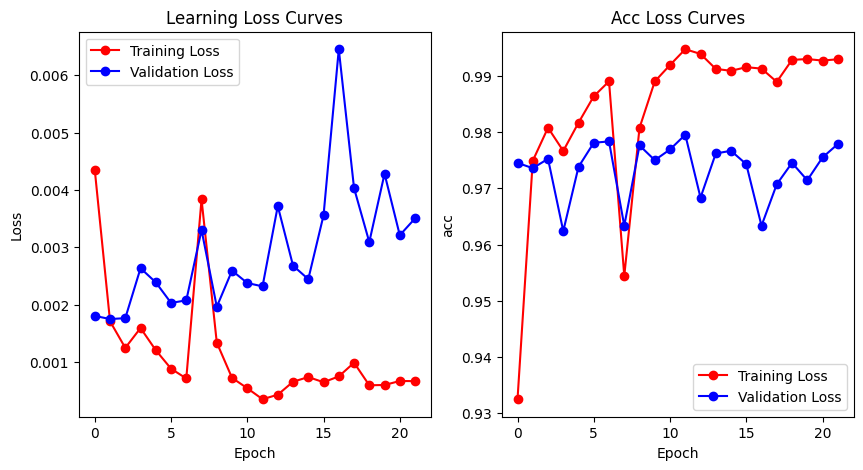

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
# Plot loss  curves
plt.subplot(1, 2, 1) 

plt.plot(train_losses,'ro-', label='Training Loss')
plt.plot(valid_losses,'bo-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Loss Curves')

# Plot loss  curves
plt.subplot(1, 2, 2) 
plt.plot(train_accs,'ro-', label='Training Loss')
plt.plot(valid_accs,'bo-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.legend()
plt.title('Acc Loss Curves')
plt.show()

Overfitting occurs because the precision of both the training set and the verification set decreases as training increases

# Test model

In [86]:
from sklearn.metrics import confusion_matrix

# Test the model
correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(f"Test Data Acc : {(100 * correct / total):.2f}%")

Test Data Acc : 97.55%


In [87]:
# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 953    1    1    0    0    4    4    1    2    1]
 [   0 1143    3    0    1    1    1    2    0    1]
 [   2    5  909    2    4    0    1    7    2    1]
 [   2    0    6  974    0    2    0    4    0    4]
 [   0    4    0    0  963    0    3    4    0   10]
 [   1    1    0    5    1  882    9    1    2    6]
 [   3    1    0    0    6    4  914    0    1    0]
 [   3    9    8    1    1    0    0  926    0   15]
 [   5    6   10    3    5    6    5    1  958   12]
 [   2    3    0    0    8    2    0    7    1  938]]


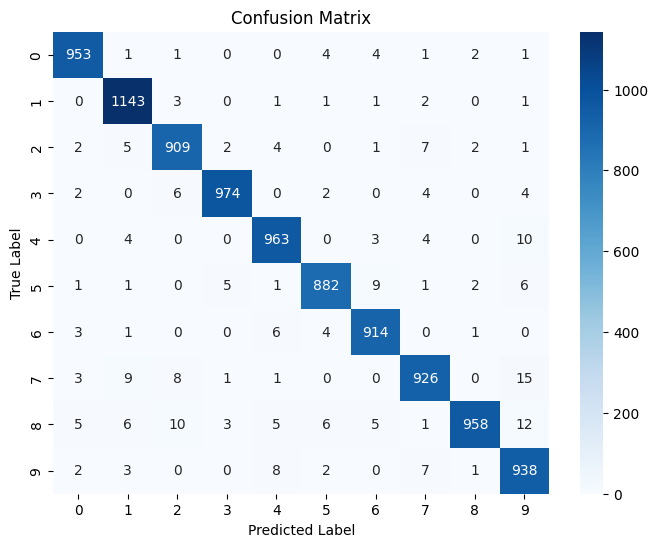

In [88]:
import seaborn as sns

classes = range(10) 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()